In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

In [2]:
df_aaindex = pd.read_csv('../data/aaindex/df_aaindex19.csv')
print(df_aaindex.shape)
df_aaindex.head(1)
tmp = df_aaindex.drop('Unnamed: 0',axis=1).T
aa2val = dict()
for aa, val in zip(tmp.index, tmp.values):
    aa2val[aa]=val

(19, 21)


In [3]:
df_detect_peptide_train = pd.read_csv('../data/df_detect_peptide_train.csv')
test = pd.read_csv('../data/df_detect_peptide_test.csv')
train, val = train_test_split(df_detect_peptide_train, test_size=0.2, random_state=7)

df = pd.concat([train, val, test], axis=0).reset_index(drop=True)

train_idx = df.iloc[:len(train), :].index
val_idx = df.iloc[len(train):len(train)+len(val), :].index
test_idx = df.iloc[len(train)+len(val):, :].index

train.head(1)

,peptide,En,Ec,E1,E2,protein,PEP,ID
595411,K.QELNEPPKQSTSFLVLQEILESEEKGDPNK.P,VYKMLQEKQELNEPP,EEKGDPNKPSGFRSV,QELNEPPKQSTSFLV,EILESEEKGDPNKPS,sp|O00151|PDLI1_HUMAN,QELNEPPKQSTSFLVLQEILESEEKGDPNK,0


# torch gpu

In [5]:
import sys
PATH_TO_REPO = "/home/bis/2021_AIhub/esm/"
sys.path.append(PATH_TO_REPO)

import torch
import esm

from tqdm.notebook import tqdm
from tqdm import tqdm, tqdm_notebook
import time
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from transformers import AdamW
# from transformers.optimization import get_cosine_schedule_with_warmup
from transformers import WarmupLinearSchedule as get_linear_schedule_with_warmup

In [6]:
##GPU 사용 시
device = torch.device("cuda")

In [7]:
esm_model, alphabet = esm.pretrained.esm1b_t33_650M_UR50S()
batch_converter = alphabet.get_batch_converter()

In [8]:
ct = 0
for child in esm_model.children():
    ct += 1
#     print(ct, child)
#     if ct < 7:
    for param in child.parameters():
        param.requires_grad = False

In [9]:
class ESMDataset(Dataset):
    def __init__(self, datasets, idxes):
        pep_idx, nterm_idx, cterm_idx, m1term_idx, m2term_idx, label_idx = idxes
        pep_data = [(label, seq) for label, seq in zip(datasets[:, label_idx], datasets[:, pep_idx])]
        nterm_data = [(label, seq) for label, seq in zip(datasets[:, label_idx], datasets[:, nterm_idx])]
        cterm_data = [(label, seq) for label, seq in zip(datasets[:, label_idx], datasets[:, cterm_idx])]
        m1_data = [(label, seq) for label, seq in zip(datasets[:, label_idx], datasets[:, m1term_idx])]
        m2_data = [(label, seq) for label, seq in zip(datasets[:, label_idx], datasets[:, m2term_idx])]
        
        labels, pep_strs, pep_tokens = batch_converter(pep_data)
        _, n_strs, n_tokens = batch_converter(nterm_data)
        _, c_strs, c_tokens = batch_converter(cterm_data)
        _, m1_strs, m1_tokens = batch_converter(m1_data)
        _, m2_strs, m2_tokens = batch_converter(m2_data)

        self.sentences = [pep_tokens, n_tokens, c_tokens, m1_tokens, m2_tokens]
        self.labels = labels

    def __getitem__(self, i):
        return (
                (self.sentences[0][i], ) + (self.sentences[1][i],) \
                + (self.sentences[2][i], ) + (self.sentences[3][i], ) + (self.sentences[4][i], ) \
                + (self.labels[i], )
               )

    def __len__(self):
        return (len(self.labels))

# [PAD] = 1, [MASK] = 21  [CLS] = 0 (special classification token), [SEP] = 2 (seperate segment), Z = 27, '-' = 30, .=29, ,=28
# J 없음
# A 2, B 25, C 23, D 13, E 9, F 18, G 6, H 21, I 12, K 15, L 4, M 20, N 17, 
# O 28, P 14, Q 16, R 10, S 8, T 11, U 26, V 7, W 22, X 24, Y 19, Z 27
# 3 5 없음

In [10]:
## Setting parameters
max_len = 30
batch_size = 256
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  1e-4

In [11]:
s = time.time()

dataset_train = train[['PEP', 'En', 'Ec', 'E1', 'E2', 'ID']].values
dataset_valid = val[['PEP', 'En', 'Ec', 'E1', 'E2', 'ID']].values
dataset_test = test[['PEP', 'En', 'Ec', 'E1', 'E2', 'ID']].values

data_train = ESMDataset(dataset_train, [0, 1, 2, 3, 4, 5])
data_valid = ESMDataset(dataset_valid, [0, 1, 2, 3, 4, 5])

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=48)
valid_dataloader = torch.utils.data.DataLoader(data_valid, batch_size=batch_size, num_workers=48)

e = time.time()
print(round(e-s, 2),'sec')

465.28 sec


In [12]:
data_test = ESMDataset(dataset_test, [0, 1, 2, 3, 4, 5])
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=48)

In [16]:
data_train[2]

(tensor([ 0,  7,  5, 17, 11,  8, 11, 16, 11, 20,  6, 14, 10, 14,  5,  5,  5,  5,
          5,  5,  5, 11, 14,  5,  7, 10,  2,  1,  1,  1,  1,  1]),
 tensor([ 0, 14, 10,  7, 20,  8, 11, 16, 10,  7,  5, 17, 11,  8, 11, 16,  2]),
 tensor([ 0,  5,  5,  5, 11, 14,  5,  7, 10, 11,  7, 14, 16, 19, 15, 19,  2]),
 tensor([ 0,  8, 11, 16, 11, 20,  6, 14, 10, 14,  5,  5,  5,  5,  5,  5,  2]),
 tensor([ 0, 30,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]),
 1)

In [21]:
zero_miss_site = torch.tensor([[ 0, 30,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
                               [ 0, 30,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]])  # '-'
result = esm_model(zero_miss_site, repr_layers=[33])['representations'][33]

In [24]:
result[0].shape

torch.Size([17, 1280])

# model

In [14]:
rnn = nn.LSTM(10, 20, 1, bidirectional=False)
inputs = torch.randn(5, 3, 10)
fwoutput, (fwhn, fwcn) = rnn(inputs)

print(fwoutput[-1, :, :]==fwhn)

rnn = nn.LSTM(10, 20, 1, bidirectional=True)
output, (hn, cn) = rnn(inputs)
# LSTM param : input_size, hidden_size, num_layers
# input shape : (seq_len, batch, input_size)
# output shape : (seq_len, batch, num_directions * hidden_size)
# hn, cn shape : (num_layers * num_directions, batch, hidden_size)

print(output.shape, hn.shape, cn.shape)

print(output[0, :, 20:] == hn[1])  # 0번 unit의 뒤 20 vector 가 reverse seq 의 output(hn)

print(output[-1, :, :20] == hn[0])  # 끝번 unit의 앞 20 vector가 forward seq 의 output(hn)

tensor([[[True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True],
         [True, True, True, True, True, True, True, True, True, True, True,
          True, True, True, True, True, True, True, True, True]]])
torch.Size([5, 3, 40]) torch.Size([2, 3, 20]) torch.Size([2, 3, 20])
tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True],
        [True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True, True, True, True]])
tensor([[True, True, True, True, True, True, True, True, True, True, True, True,
       

In [11]:
class ESMClassifier(nn.Module):
    def __init__(self,
                 esm,
                 num_classes=1,
                 params=None):
        
        super(ESMClassifier, self).__init__()
        self.esm = esm
        self.pep_lstm1 = nn.LSTM(input_size=1280, hidden_size=128, batch_first=True)
        self.pep_drop1 = nn.Dropout(p=0.2)
        
        self.ts_lstm1 = nn.LSTM(input_size=1280, hidden_size=64, batch_first=True)
        self.ts_drop1 = nn.Dropout(p=0.2)
                
        self.fc1 = nn.Linear(384, 128)
        self.fc_drop1 = nn.Dropout(p=0.2)
        self.fc2 = nn.Linear(128, 1)


#     def gen_attention_mask(self, token_ids, valid_length):
#         attention_mask = torch.zeros_like(token_ids)
#         for i, v in enumerate(valid_length):
#             attention_mask[i][:v] = 1
#         return attention_mask.float()

    def forward(self, token_ids, en_token_ids, ec_token_ids, e1_token_ids, e2_token_ids):
#         attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        pep_embed = self.esm(token_ids, repr_layers=[33])['representations'][33]
        pep_lstm, (pep_hn, __) = self.pep_lstm1(pep_embed)
        pep_hn = self.pep_drop1(pep_hn)
        
        en_embed = self.esm(en_token_ids, repr_layers=[33])['representations'][33]
        ec_embed = self.esm(ec_token_ids, repr_layers=[33])['representations'][33]
        e1_embed = self.esm(e1_token_ids, repr_layers=[33])['representations'][33]
        e2_embed = self.esm(e2_token_ids, repr_layers=[33])['representations'][33]
        
        en_lstm, (en_hn, __) = self.ts_lstm1(en_embed)
        en_lstm = self.ts_drop1(en_hn)
        
        ec_lstm, (ec_hn, __) = self.ts_lstm1(ec_embed)
        ec_lstm = self.ts_drop1(ec_hn)
        
        e1_lstm, (e1_hn, __) = self.ts_lstm1(e1_embed)
        e1_lstm = self.ts_drop1(e1_hn)
        
        e2_lstm, (e2_hn, __) = self.ts_lstm1(e2_embed)
        e2_lstm = self.ts_drop1(e2_hn)
        
        merge = torch.cat([pep_hn[0], en_hn[0], ec_hn[0], e1_hn[0], e2_hn[0]], dim=1)

        merge = self.fc1(merge)
        merge = self.fc_drop1(merge)
        merge = self.fc2(merge)
        
        out = torch.sigmoid(merge)
        return out

In [12]:
model = ESMClassifier(esm_model).to(device)

In [13]:
model.eval()

ESMClassifier(
  (esm): ProteinBertModel(
    (embed_tokens): Embedding(33, 1280, padding_idx=1)
    (layers): ModuleList(
      (0): TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1280, out_features=5120, bias=True)
        (fc2): Linear(in_features=5120, out_features=1280, bias=True)
        (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      )
      (1): TransformerLayer(
        (self_attn): MultiheadAttention(
          (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (v_proj): Linear(in_fe

In [14]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)  # 1,115,905

+------------------------+------------+
|        Modules         | Parameters |
+------------------------+------------+
| pep_lstm1.weight_ih_l0 |   655360   |
| pep_lstm1.weight_hh_l0 |   65536    |
|  pep_lstm1.bias_ih_l0  |    512     |
|  pep_lstm1.bias_hh_l0  |    512     |
| ts_lstm1.weight_ih_l0  |   327680   |
| ts_lstm1.weight_hh_l0  |   16384    |
|  ts_lstm1.bias_ih_l0   |    256     |
|  ts_lstm1.bias_hh_l0   |    256     |
|       fc1.weight       |   49152    |
|        fc1.bias        |    128     |
|       fc2.weight       |    128     |
|        fc2.bias        |     1      |
+------------------------+------------+
Total Trainable Params: 1115905


1115905

In [15]:
# Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()
# loss_fn = F.binary_cross_entropy()

t_total = len(train_dataloader) * num_epochs
# warmup_step = int(t_total * warmup_ratio)

# scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps=warmup_step, t_total=t_total)

def calc_accuracy(X,Y):
    train_acc = ((X>0.5)==Y).sum().data.cpu().numpy() / len(Y)
    return train_acc

In [16]:
best_acc = 0
for e in range(num_epochs):
    t0 = time.time()
    train_acc = 0.0
    test_acc = 0.0
    
    model.train()
    for batch_id, (pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids, label) in enumerate(train_dataloader):
#         print(batch_id, round(time.time()-t0, 2))  # batch256->2100 loop, each 5 sec -> per 1 epoch, 3h
        
        pep_token_ids = pep_token_ids.long().to(device)
        n_token_ids = n_token_ids.long().to(device)
        c_token_ids = c_token_ids.long().to(device)
        m1_token_ids = m1_token_ids.long().to(device)
        m2_token_ids = m2_token_ids.long().to(device)
        label = torch.reshape(label.float(), (-1, 1)).to(device)
        
        pred = model(pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids)
        loss = F.binary_cross_entropy(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_acc += calc_accuracy(pred, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {} time {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1), round(time.time()-t0, 2)))
        
    print("epoch {} train acc {} time {}".format(e+1, train_acc / (batch_id+1), round(time.time()-t0,2)))
    
    model.eval()
    for batch_id, (pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids, label) in enumerate(valid_dataloader):
        pep_token_ids = pep_token_ids.long().to(device)
        n_token_ids = n_token_ids.long().to(device)
        c_token_ids = c_token_ids.long().to(device)
        m1_token_ids = m1_token_ids.long().to(device)
        m2_token_ids = m2_token_ids.long().to(device)
        label = label.long().to(device)
        label = torch.reshape(label, (-1, 1))
        pred = model(pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids)
        
        test_acc += calc_accuracy(pred, label)
    if (test_acc / (batch_id+1))> best_acc:
        best_acc=test_acc
        torch.save({"best_acc":best_acc / (batch_id+1),"model":model.state_dict()},f'./lowParam/low.pl')
        print(f"best_acc: {best_acc}")
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))

epoch 1 batch id 1 loss 0.7014474272727966 train acc 0.484375 time 13.23
epoch 1 batch id 201 loss 0.47278064489364624 train acc 0.734491604477612 time 2903.05
epoch 1 batch id 401 loss 0.46440577507019043 train acc 0.7491817331670823 time 5813.78
epoch 1 batch id 601 loss 0.4463101923465729 train acc 0.760412333610649 time 8728.18
epoch 1 batch id 801 loss 0.45861536264419556 train acc 0.7678341526217228 time 11642.14
epoch 1 batch id 1001 loss 0.47250211238861084 train acc 0.7724658154345654 time 14541.81
epoch 1 batch id 1201 loss 0.42056262493133545 train acc 0.7769729652373022 time 17461.81
epoch 1 batch id 1401 loss 0.4988987147808075 train acc 0.7810910733404711 time 20497.99
epoch 1 batch id 1601 loss 0.4582826495170593 train acc 0.784377927857589 time 23535.84
epoch 1 batch id 1801 loss 0.43541669845581055 train acc 0.7872904809827873 time 26573.63
epoch 1 batch id 2001 loss 0.422135591506958 train acc 0.7895427286356822 time 29612.9
epoch 1 train acc 0.7909517819309928 time 3

epoch 8 batch id 1801 loss 0.3338266909122467 train acc 0.8522760792615214 time 25092.12
epoch 8 batch id 2001 loss 0.35759472846984863 train acc 0.852351168165917 time 27870.33
epoch 8 train acc 0.8526160420029594 time 29440.64
epoch 8 test acc 0.8223631709039547
epoch 9 batch id 1 loss 0.32649242877960205 train acc 0.85546875 time 13.27
epoch 9 batch id 201 loss 0.3079838752746582 train acc 0.8559351679104478 time 2169.78
epoch 9 batch id 401 loss 0.32092398405075073 train acc 0.8559168485037406 time 4325.0
epoch 9 batch id 601 loss 0.3183908760547638 train acc 0.8558457258735441 time 6481.06
epoch 9 batch id 801 loss 0.38080787658691406 train acc 0.8565903948189763 time 8636.99
epoch 9 batch id 1001 loss 0.32872018218040466 train acc 0.855726304945055 time 10792.85
epoch 9 batch id 1201 loss 0.31729385256767273 train acc 0.8559598771856786 time 12948.38
epoch 9 batch id 1401 loss 0.4225287437438965 train acc 0.8564808618843683 time 15104.64
epoch 9 batch id 1601 loss 0.3275820016860

In [21]:
pred = []
model.eval()
with torch.no_grad():
    for batch_id, (pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids, label) in enumerate(test_dataloader):
        pep_token_ids = pep_token_ids.long().to(device)
        n_token_ids = n_token_ids.long().to(device)
        c_token_ids = c_token_ids.long().to(device)
        m1_token_ids = m1_token_ids.long().to(device)
        m2_token_ids = m2_token_ids.long().to(device)
        label = label.long().to(device)
        label = torch.reshape(label, (-1, 1))

        pred_batch = model(pep_token_ids, n_token_ids, c_token_ids, m1_token_ids, m2_token_ids)
        pred += list(pred_batch)
        test_acc += calc_accuracy(pred_batch, label)

              precision    recall  f1-score   support

           0       0.83      0.82      0.83     66996
           1       0.82      0.83      0.83     66996

    accuracy                           0.83    133992
   macro avg       0.83      0.83      0.83    133992
weighted avg       0.83      0.83      0.83    133992



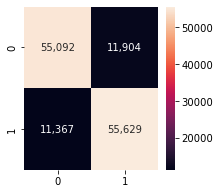

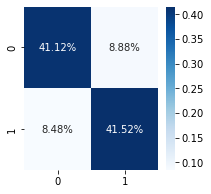

accuracy: 0.8263254522658069


In [22]:
y_test = test.ID.values
y_pred = [1 if _ >= 0.5 else 0 for _ in pred]
print(classification_report(y_test, y_pred))
cf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
plt.show()
plt.figure(figsize=(3, 3))
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

print('accuracy:', sum(np.array(y_pred)==y_test)/ len (y_pred))

In [35]:
probs = [_.cpu().numpy() for _ in pred]

rf auc : 0.9022046666888106


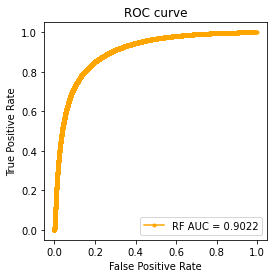

In [36]:
rf_auc = roc_auc_score(y_test, probs)


print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model_high
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [37]:
torch.save({"model":model.state_dict()},f'./lowParam/low2.pl')